### Variational Classification

Full implementation of [Rodney Osodo](https://medium.com/qiskit/building-a-quantum-variational-classifier-using-real-world-data-809c59eb17c2)

In [1]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

In [2]:
import numpy as np
np.random.seed(algorithm_globals.random_seed)

In [3]:
from qiskit_machine_learning.datasets import ad_hoc_data

# We create 20 training data points and 5 test data points
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(
        training_size=20,
        test_size=5,
        n=2,
        gap=0.3,
        one_hot=False
    )
)

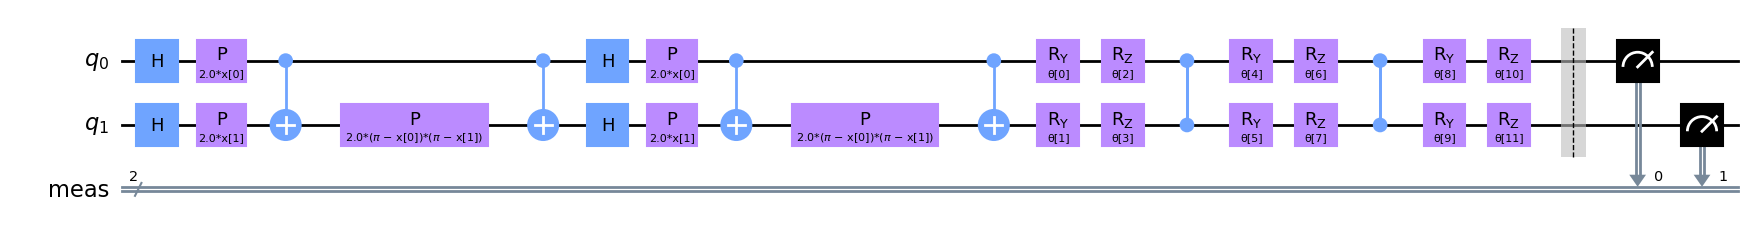

In [4]:
# We create a data encoding circuit using `ZZFeatureMap` and create a variational with Y, Z rotation gates and a phase gate using `TwoLocal`
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FROM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FROM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw('mpl')

In [5]:
# Create a function that associates the right parameters to the variational circuit
def circuit_instance(data, variational):
    parameters = {}

    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FROM.ordered_parameters):
        parameters[p] = variational[i]
    
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

In [6]:
# Class assignment function; when parity is even it returns 1 and when parity is odd is returns 0
def parity(bitstring):
    hamming_weight = sum(int(k) for k in list (bitstring))
    return (hamming_weight + 1) % 2

In [7]:
# Returns probability distrubution of labeled classes and experimental counts of running the quantum circuits multiple times
def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}

    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots

    return probabilities

In [8]:
from qiskit import BasicAer, execute

def classification_probability(data, variational):
    circuits = [circuit_instance(d, variational) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    classifaction = [label_probability(results.get_counts(c)) for c in circuits]

    return classifaction

In [9]:
def cross_entropy_loss(classification, expected):
    p = classification.get(expected)
    return -np.log(p + 1e-10)

In [10]:
def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)
    cost = 0

    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    
    cost /= len(data)
    return cost

In [11]:
# Optimizer Log & Optimizer
class OptimizerLog():
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

In [12]:
from qiskit.algorithms.optimizers import SPSA

log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

initial_points = np.array(
    [
    3.28559355, 5.48514978, 5.13099949,
    0.88372228, 4.08885928, 2.45568528,
    4.92364593, 5.59032015, 3.66837805,
    4.84632313, 3.60713748, 2.43546000
    ]
)

def objective_function(variational):
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

results = optimizer.minimize(
    objective_function,
    initial_points
)

opt_var = results.x
opt_value = results.fun

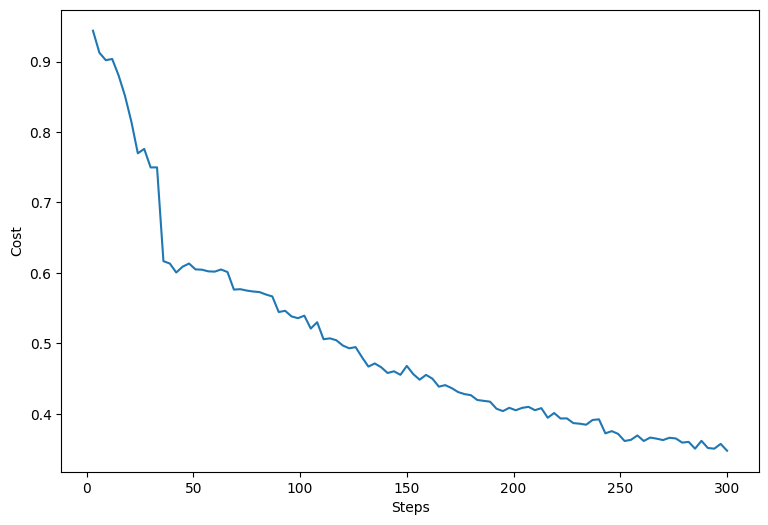

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

In [16]:
def test_classifier(data, labels, variational):
    probability = classification_probability(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]

    accuracy = 0

    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    
    accuracy /= len(labels)

    return accuracy, predictions

accuracy, predictions = test_classifier(TEST_DATA, TEST_LABELS, opt_var)
accuracy


0.7

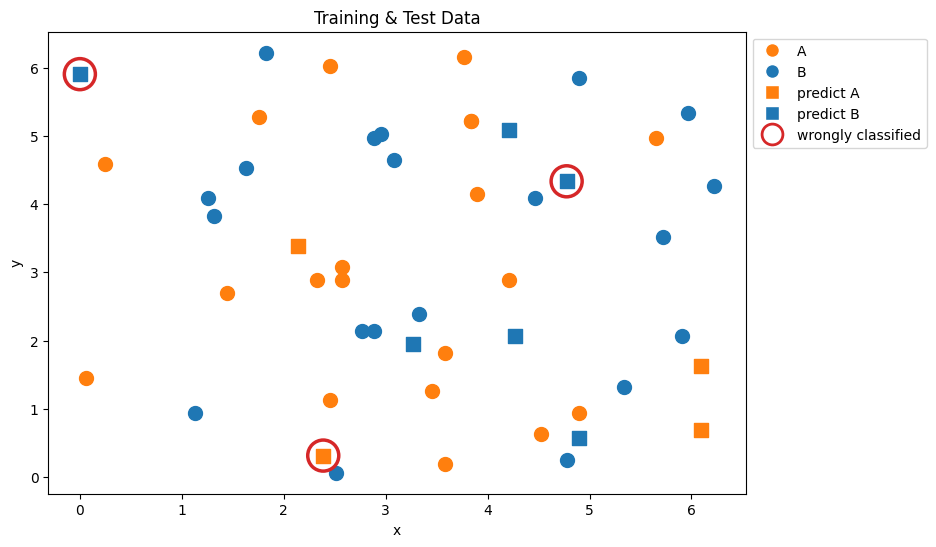

In [17]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(TRAIN_DATA, TRAIN_LABELS):
    COLOR = 'C0' if label == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='o', s=100, color=COLOR)

for feature, label, pred in zip(TEST_DATA, TEST_LABELS, predictions):
    COLOR = 'C0' if pred == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='s', s=100, color=COLOR)
    if label != pred:  # mark wrongly classified
        plt.scatter(
            feature[0], 
            feature[1], 
            marker='o', 
            s=500,
            linewidths=2.5, 
            facecolor='none', 
            edgecolor='C3'
        )

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3', label='wrongly classified', mew=2, ms=15)
]

plt.legend(
    handles=legend_elements, 
    bbox_to_anchor=(1, 1),
    loc='upper left'
)

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Qiskit Implementation

In [39]:
from qiskit_machine_learning.datasets import ad_hoc_data

# We create 20 training data points and 5 test data points
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(
        training_size=20,
        test_size=5,
        n=2,
        gap=0.3,
        one_hot=False
    )
)

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

train_label_oh = encoder.fit_transform(
    TRAIN_LABELS.reshape(-1, 1)
).toarray()

test_label_oh = encoder.fit_transform(
    TEST_LABELS.reshape(-1, 1)
).toarray()

In [40]:
initial_point = np.array(
    [
        0.3200227 , 0.6503638 , 0.55995053,
        0.96566328, 0.38243769, 0.90403094,
        0.82271449, 0.26810137, 0.61076489,
        0.82301609, 0.11789148, 0.29667125
    ]
)

In [41]:
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc_log = OptimizerLog()

vqc = VQC(
    feature_map=FEATURE_MAP,
    ansatz=VAR_FROM,
    loss='cross_entropy',
    optimizer=SPSA(callback=vqc_log.update),
    initial_point=initial_points,
    quantum_instance=BasicAer.get_backend('qasm_simulator')
)

vqc.fit(TRAIN_DATA, train_label_oh)

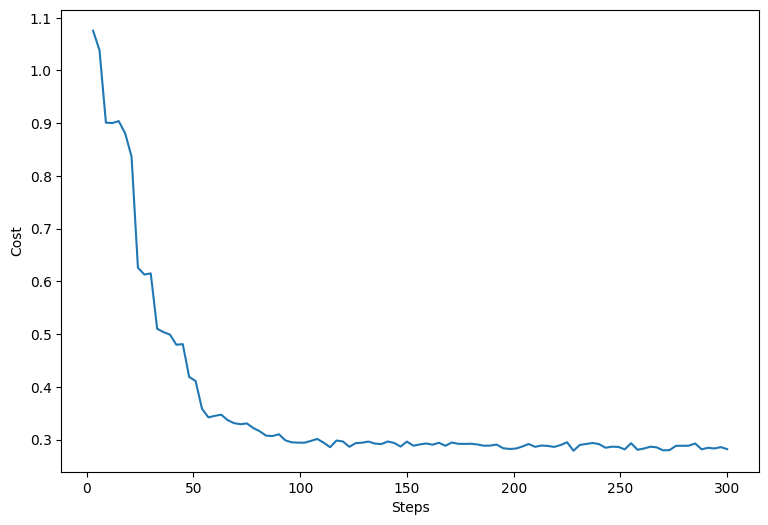

In [42]:
fig = plt.figure(figsize=(9, 6))
plt.plot(vqc_log.evaluations, vqc_log.costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.show()

In [45]:
vqc.score(TEST_DATA, test_label_oh)

1.0